In [1]:
# !pip install scanpy

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import gzip

In [3]:
# !wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3681nnn/GSM3681518/suppl/GSM3681518%5FMNC%5FRNA%5Fcounts.tsv.gz
# !gzip -d GSM3681518_MNC_RNA_counts.tsv.gz

In [4]:
adata = sc.read_csv('GSM3681518_MNC_RNA_counts.tsv', delimiter='\t')
adata = adata.T
adata

AnnData object with n_obs × n_vars = 33454 × 17009

In [5]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.25.2 scipy==1.11.4 pandas==2.0.3 scikit-learn==1.2.2 statsmodels==0.14.2 igraph==0.11.4 pynndescent==0.5.12


In [6]:
print("Cells before:", adata.shape[0])
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
print("Cells after:", adata.shape[0])

Cells before: 33454
filtered out 6 cells that have less than 200 genes expressed
filtered out 1 genes that are detected in less than 3 cells
Cells after: 33448


normalizing counts per cell
    finished (0:00:01)


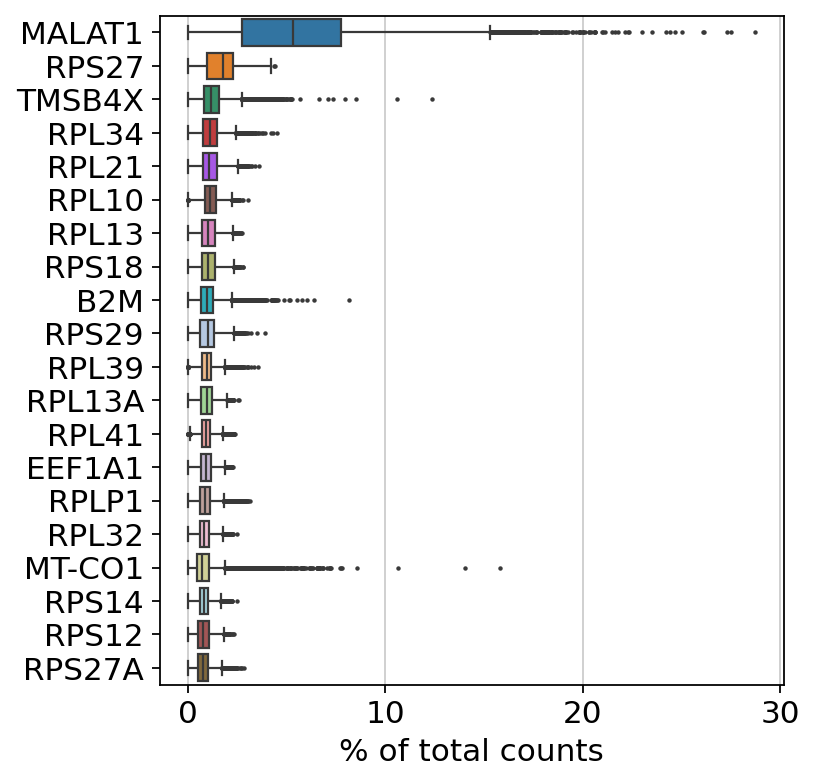

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [8]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

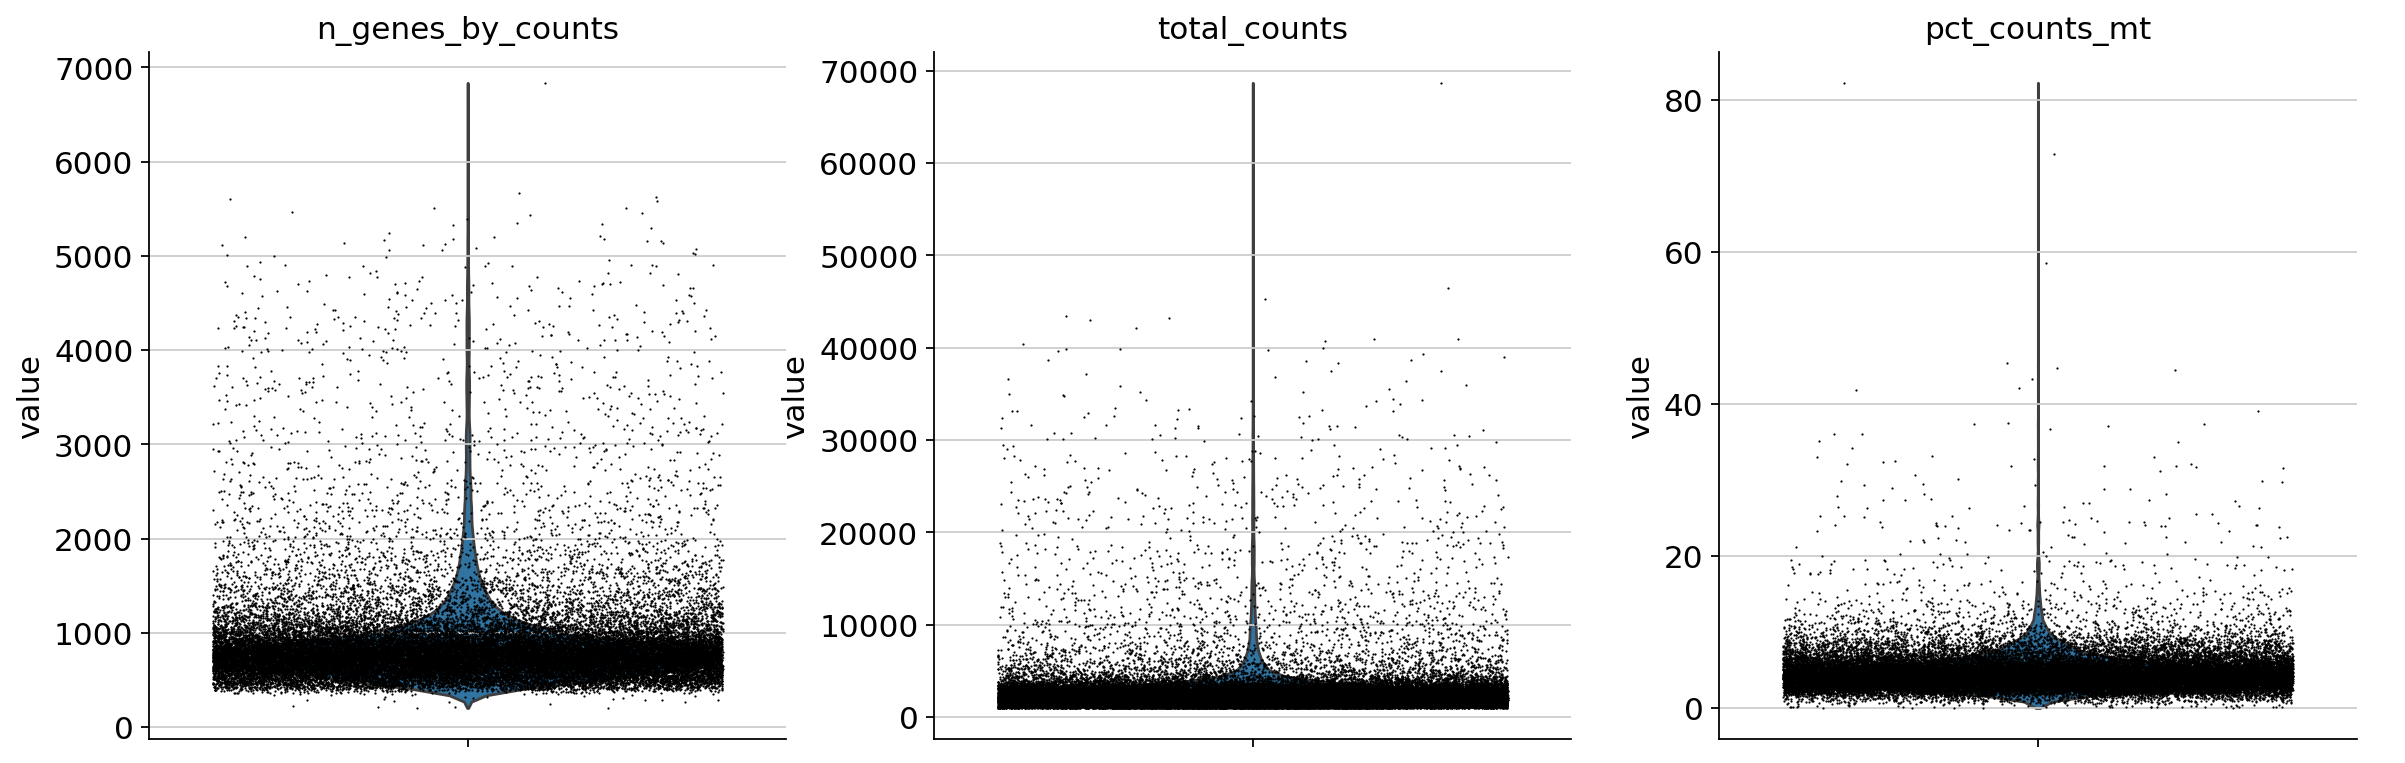

In [9]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

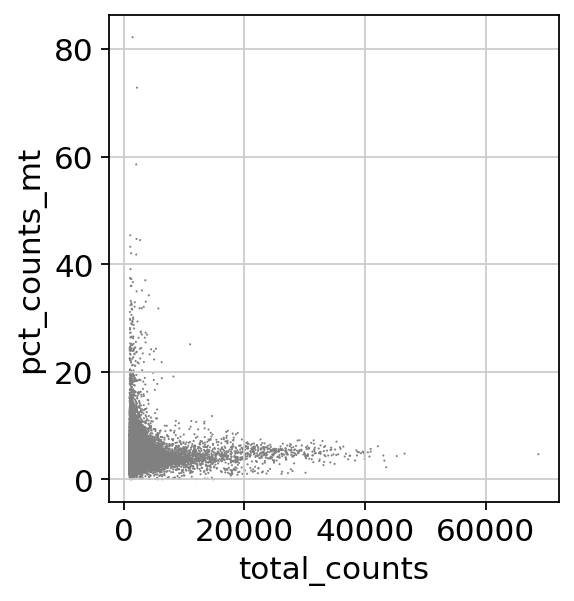

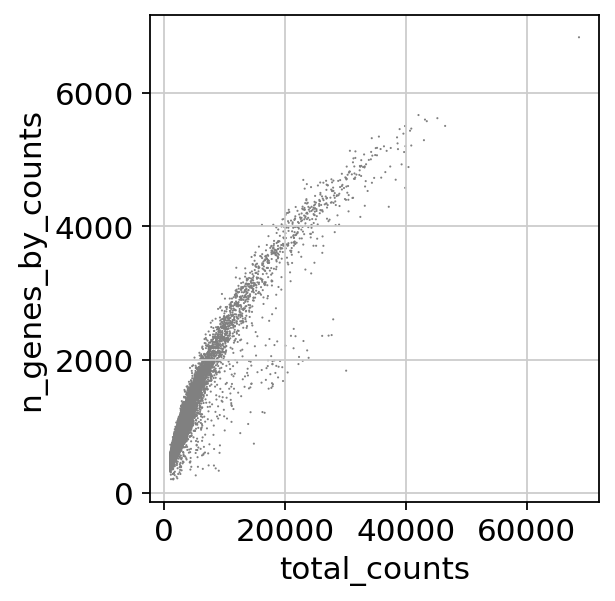

In [10]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [11]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [13]:
sc.pp.log1p(adata)

In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


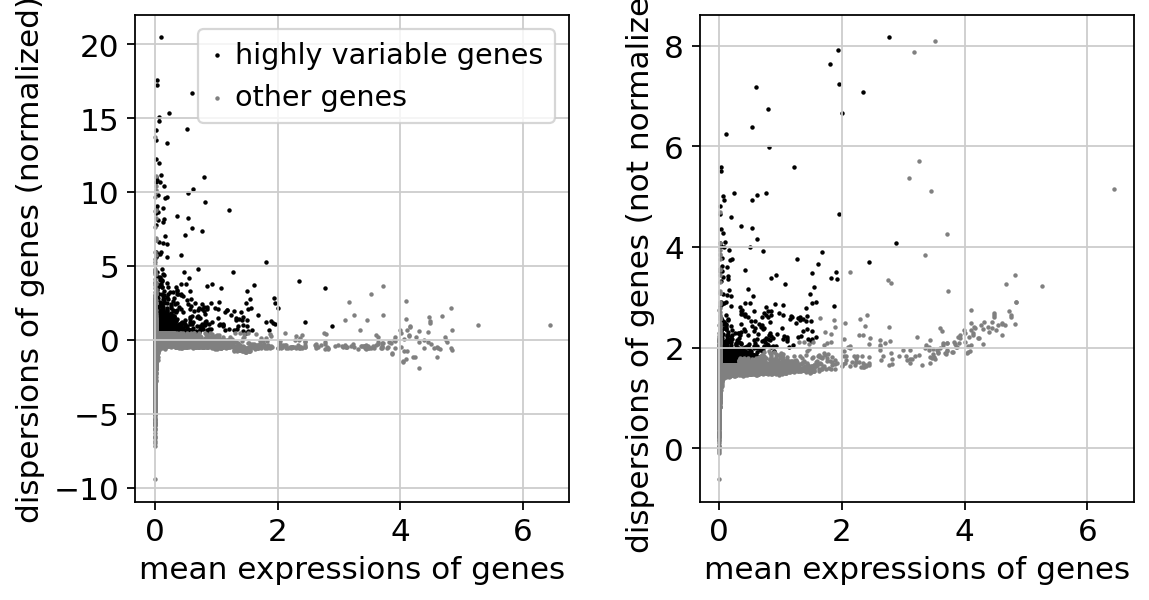

In [15]:
sc.pl.highly_variable_genes(adata)

In [16]:
adata.raw = adata

In [17]:
adata = adata[:, adata.var.highly_variable]

In [18]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:41)


In [19]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

In [20]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:17)


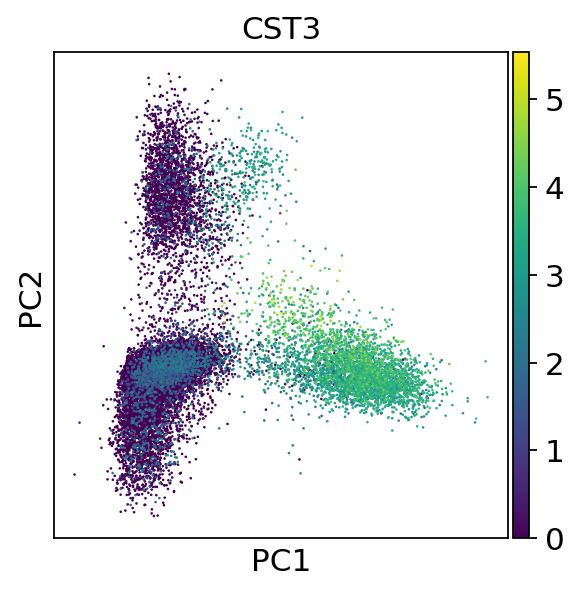

In [21]:
sc.pl.pca(adata, color="CST3")

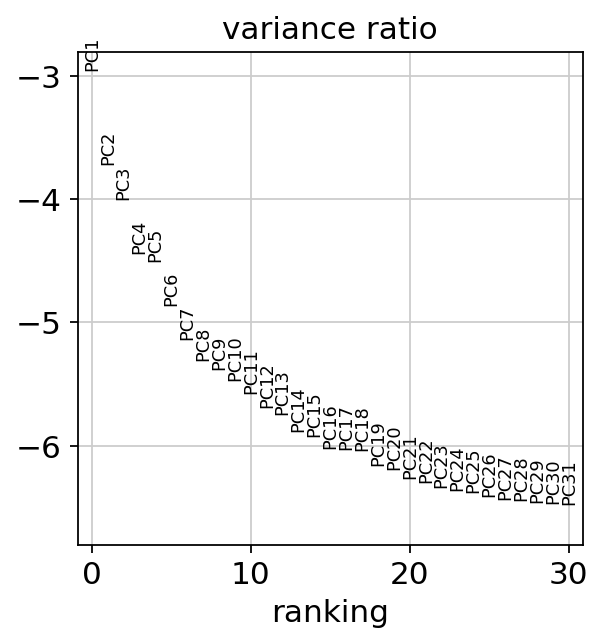

In [22]:
sc.pl.pca_variance_ratio(adata, log=True)

In [23]:
adata

AnnData object with n_obs × n_vars = 21839 × 1063
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

In [24]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:54)


## Embedding the neighborhood graph

In [25]:
!pip install igraph
!pip install leidenalg

In [26]:
sc.tl.leiden(adata)

running Leiden clustering


<ipython-input-26-a9ad6348435f>:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:51)


In [27]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:03)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:43)


In [28]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:27)


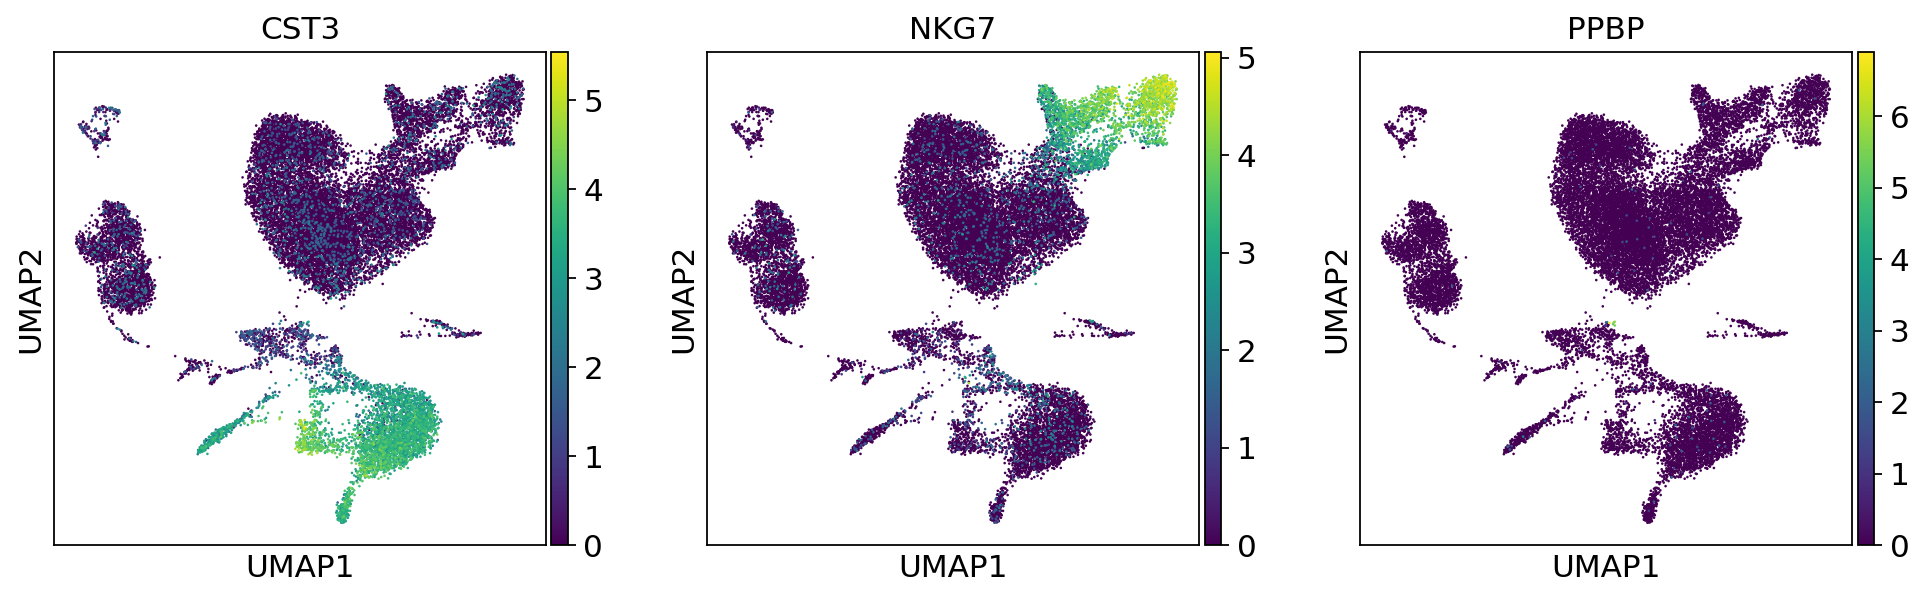

In [29]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

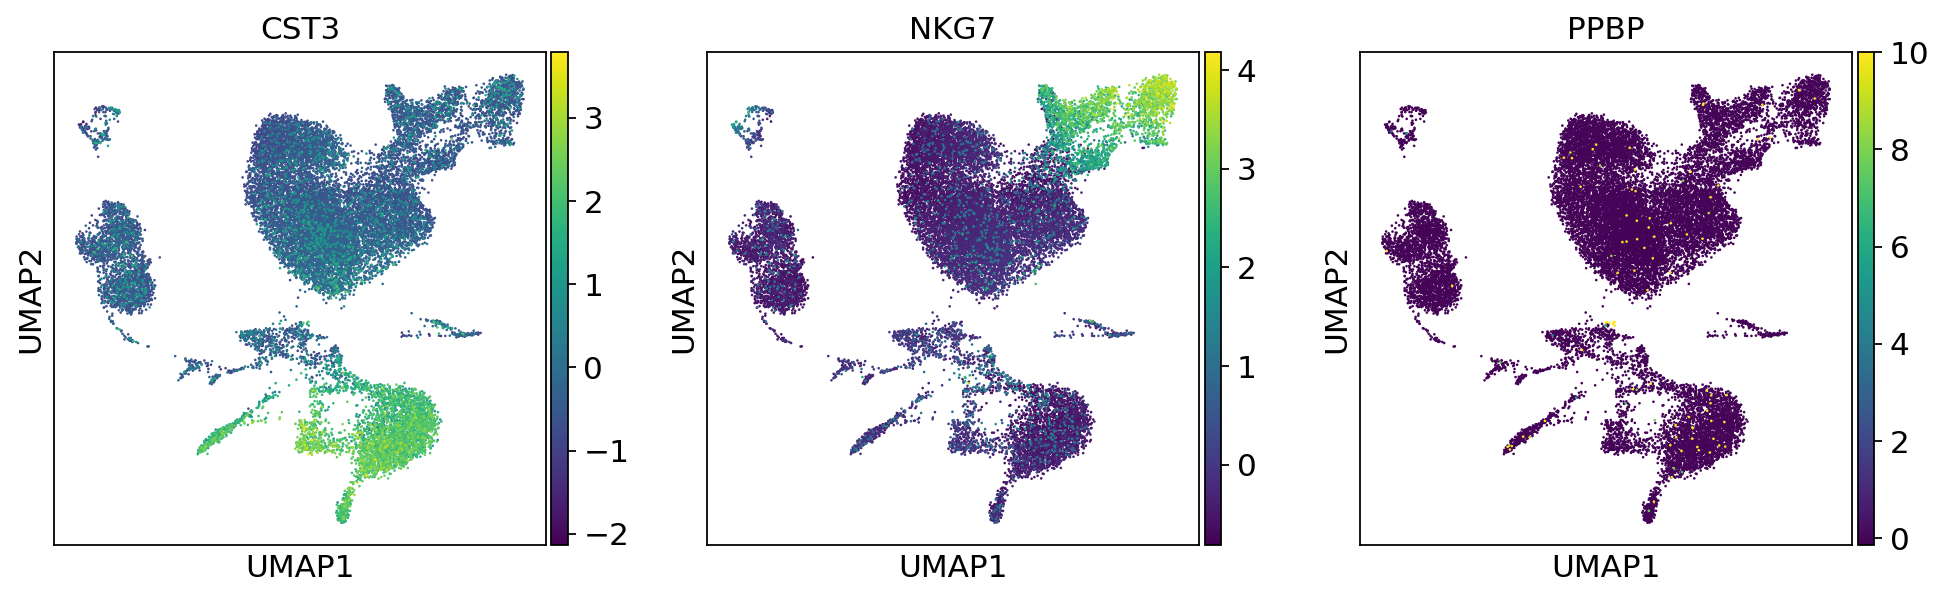

In [30]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], use_raw=False)

## Clustering the neighborhood graph

In [31]:
sc.tl.leiden(
    adata,
    resolution=0.08,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


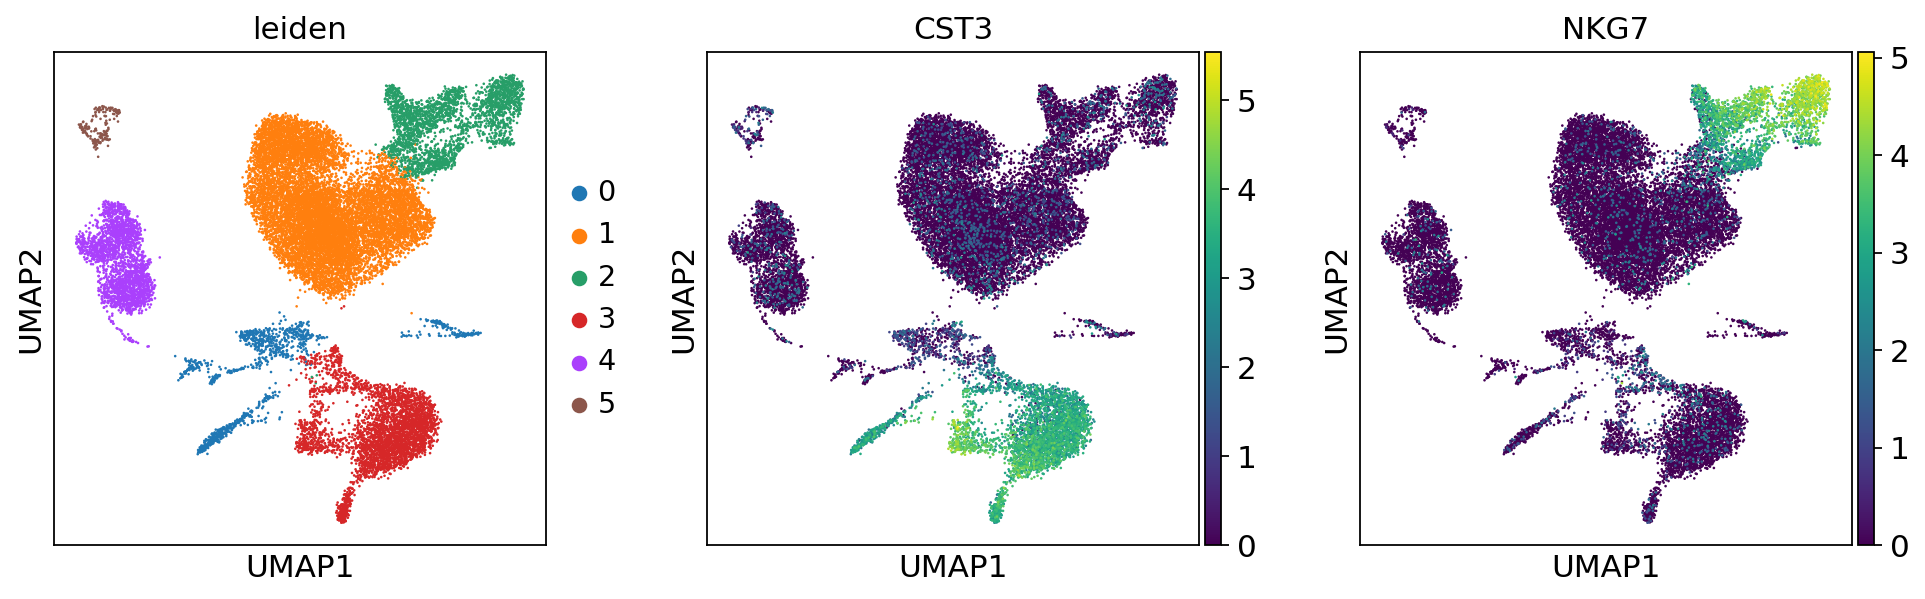

In [32]:
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"])

## Finding marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:20)


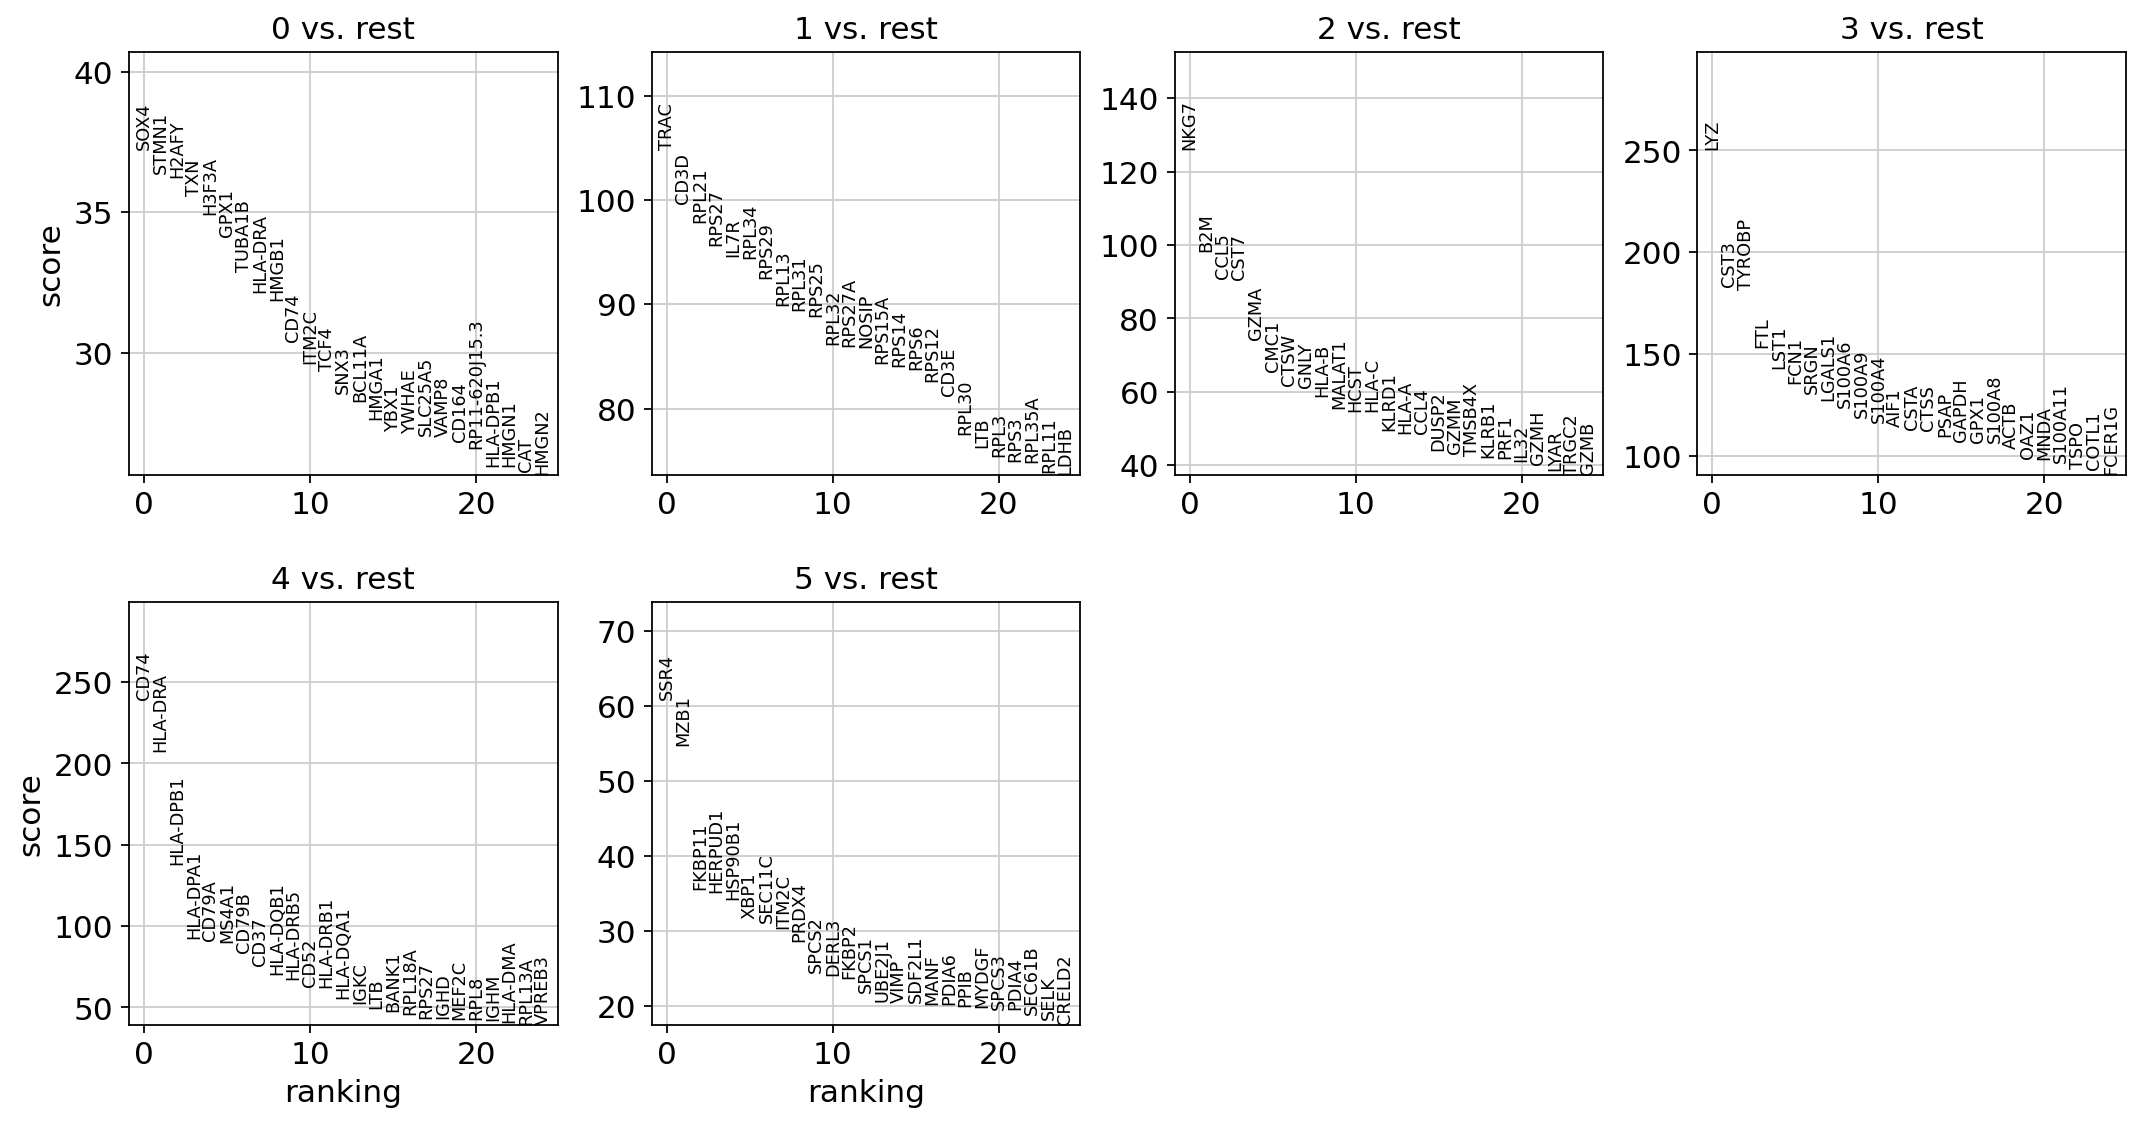

In [33]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [34]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:01:50)


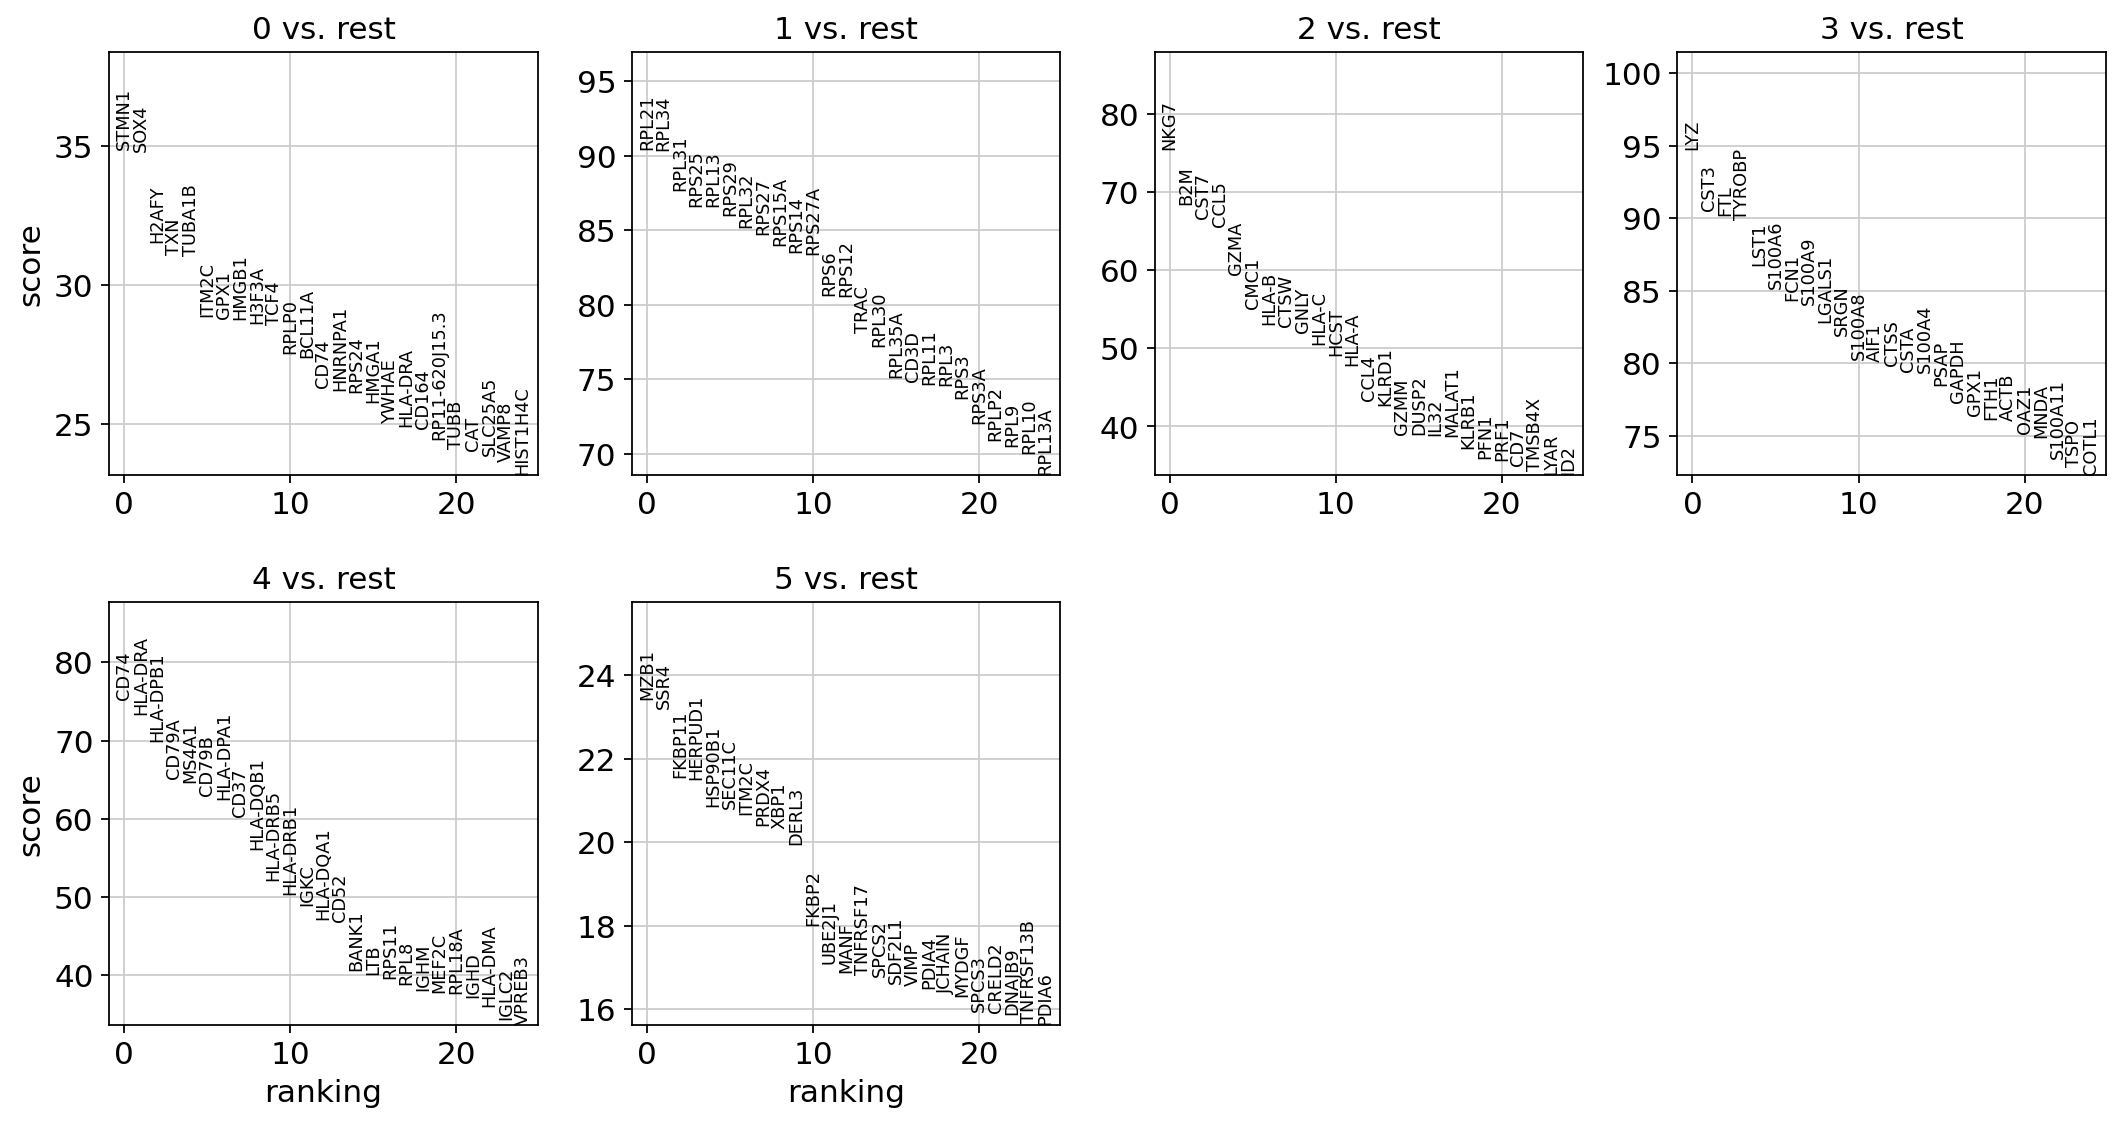

In [35]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [36]:
# sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [48]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["STMN1", "TRAC", "CD3D", "CD74", "MZB1", "IGKC"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

ranking genes
    finished (0:00:41)


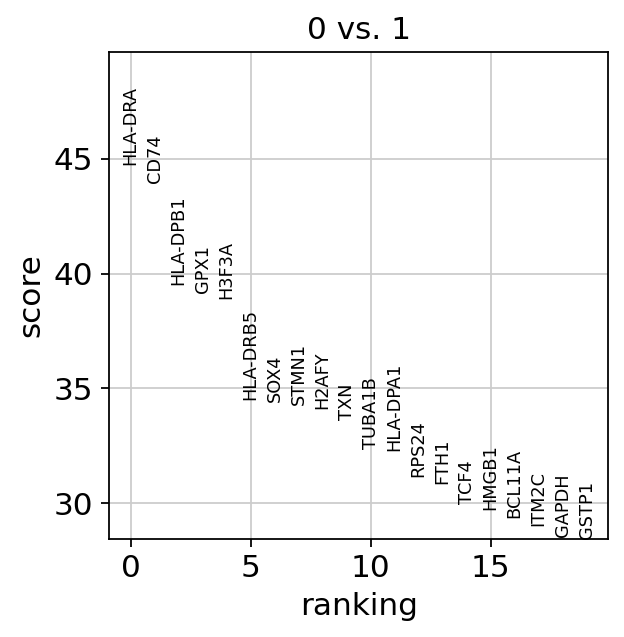

In [38]:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/__init__.py:1303: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


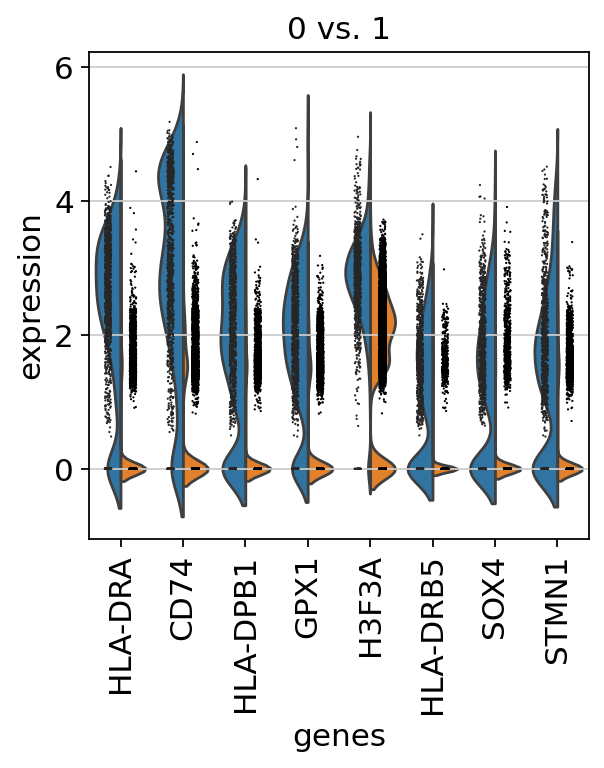

In [39]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/__init__.py:1303: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


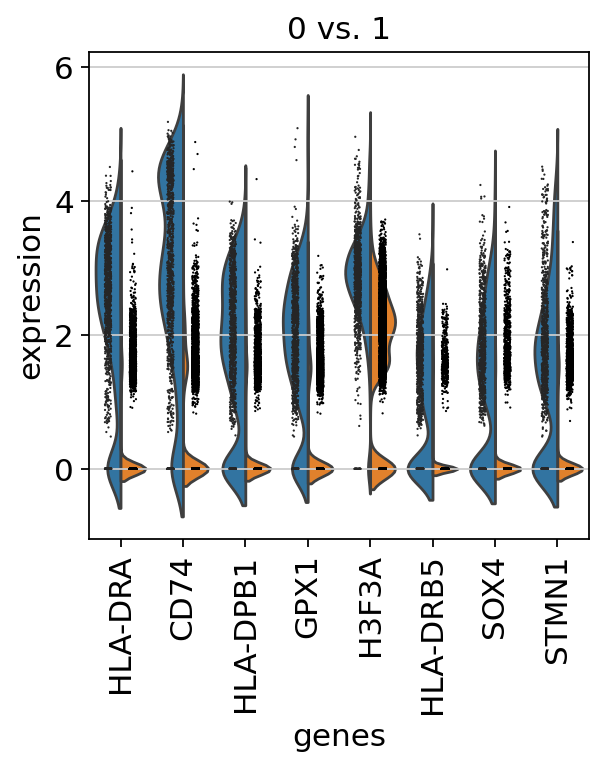

In [40]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

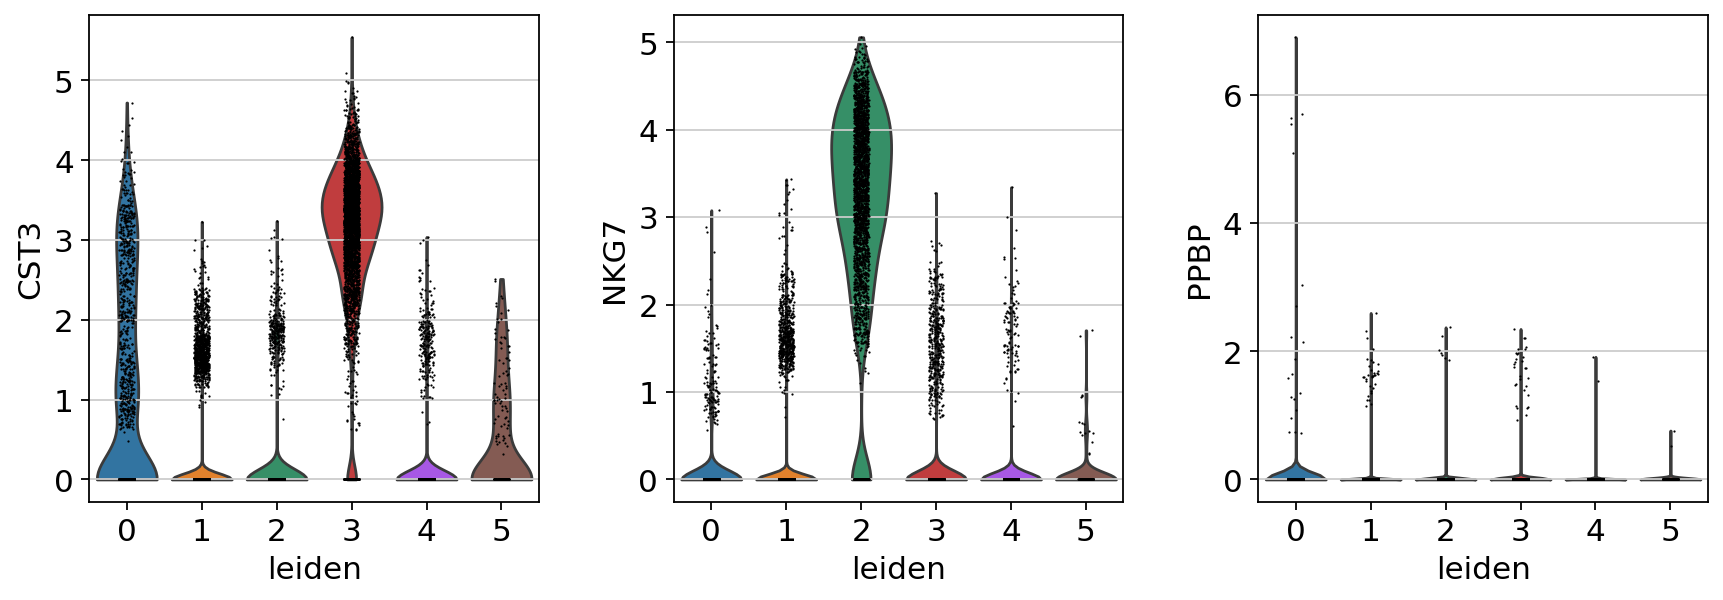

In [41]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")

In [42]:
new_cluster_names = [
    "B",
    "CD4 T",
    "NK",
    "CD14+ Monocytes",
    "Macrophages",
    "Plasma B cells"
]
adata.rename_categories("leiden", new_cluster_names)

Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.


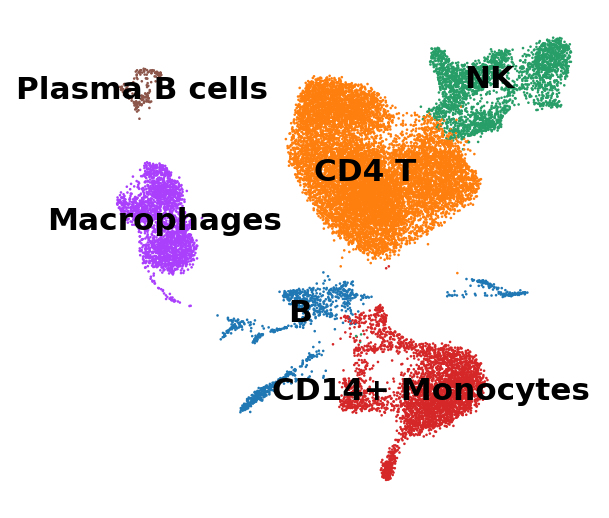

In [43]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

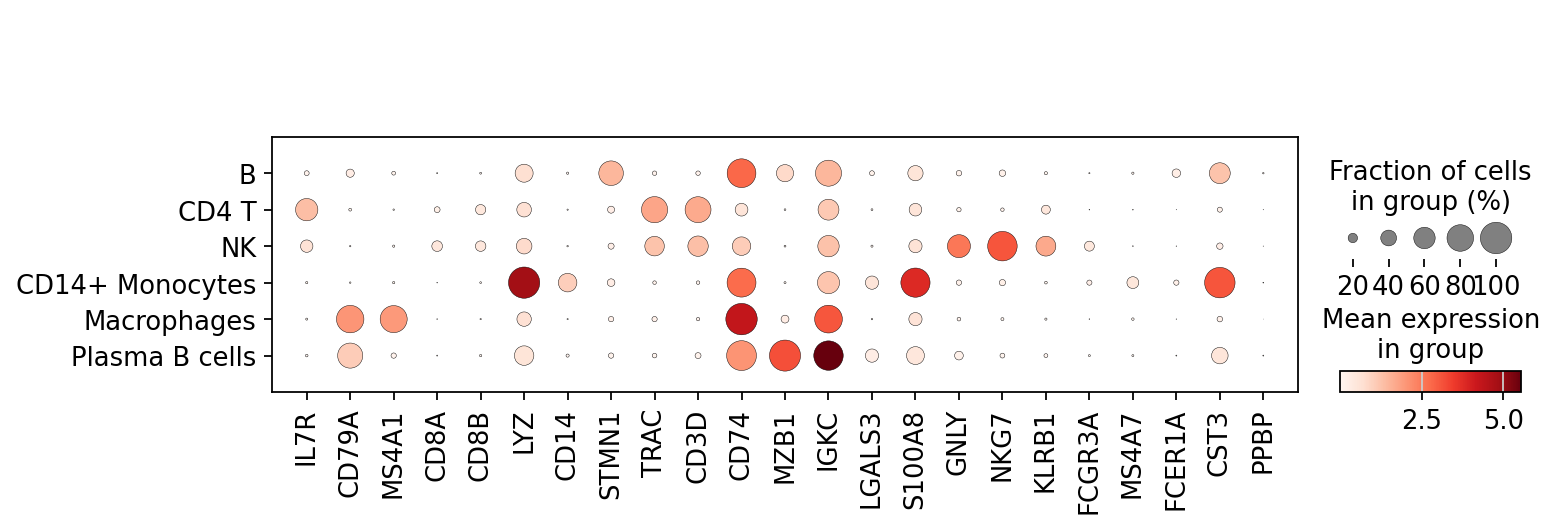

In [49]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden");

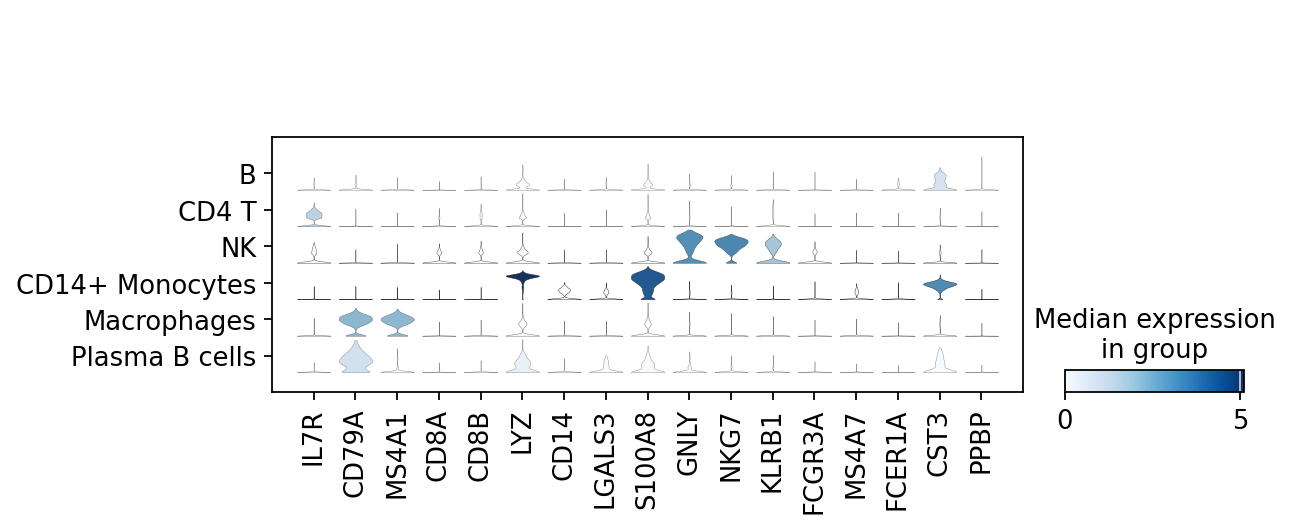

In [45]:
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden");